In [3]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

plt.rcParams['figure.figsize'] = (15, 5)

stoke = 2
font_scale = 0.5

area_percentage_threshold = 0.025
variance_threshold = 200
background_similarity_threshold = 30
area_overlapping_threshold = 0.25
fraction_ratio_threshold = 0.25

(340, 812, 3)


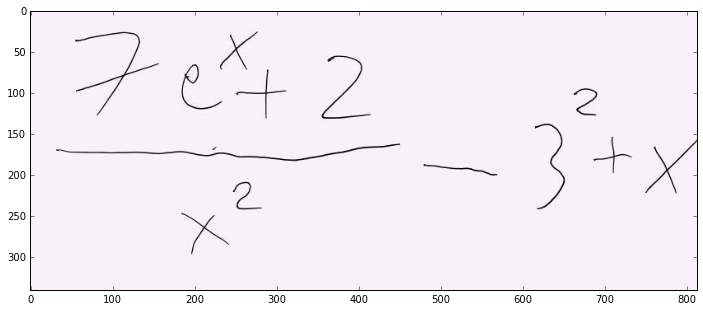

In [4]:
# Load the image
#img = cv2.imread('test.png')
#img = cv2.imread('no_grid.png')
#img = cv2.imread('grid.jpg')
img = cv2.imread('fraction.png')

plt.imshow(img)

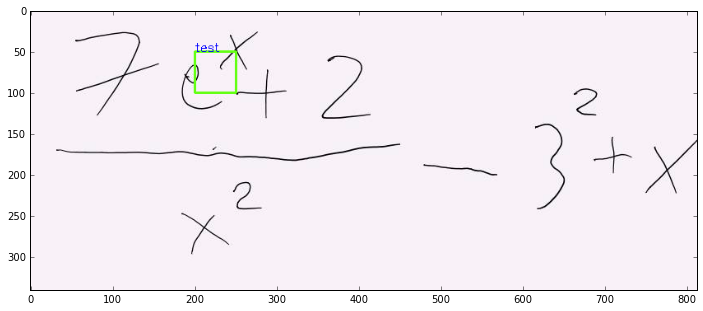

In [15]:
def draw_rect(image, rect, rect_color=(0,0,0), caption="", caption_color=(0,0,0)):
    global stoke
    global font_scale
    
    [x,y,w,h] = rect
    
    cv2.rectangle(image, (x,y), (x+w,y+h), rect_color, stoke)
    cv2.putText(image, caption, (x,y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, caption_color)    

res = img.copy()
draw_rect(res, [200, 50, 50, 50], rect_color=(100, 255, 20), caption="test", caption_color=(0, 0, 255))

plt.imshow(res)

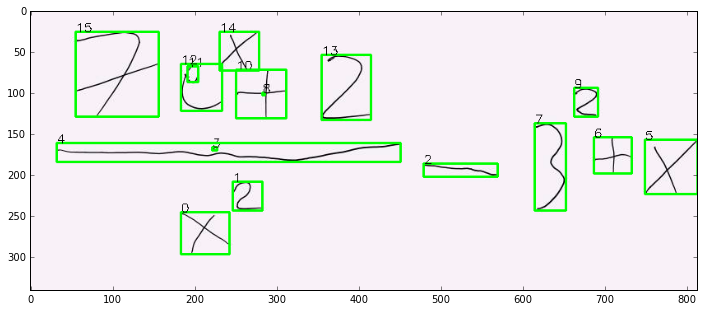

In [16]:
def is_empty_rect(rect, img_average, rectangles):
    global variance_threshold
    global background_similarity_threshold
    [x,y,w,h] = rect
    
    has_low_variance = np.var(img[y:y+h, x:x+w]) < variance_threshold
    is_background = abs(np.average(img[y:y+h, x:x+w]) - img_average) < background_similarity_threshold
    
    # remove boxes with high variance and the same color as the background
    return has_low_variance and is_background

def find_rects(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    gray = cv2.medianBlur(gray, 5)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)    
    ctrs, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    img_average = np.average(img)
        
    rectangles = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    return [ rect for rect in rectangles if not is_empty_rect(rect, img_average, rectangles) ]
    
    
rectangles = find_rects(img)
res = img.copy()

for k in range(len(rectangles)):
    draw_rect(res, rectangles[k], rect_color=(0,255,0), caption=str(k))

plt.imshow(res)

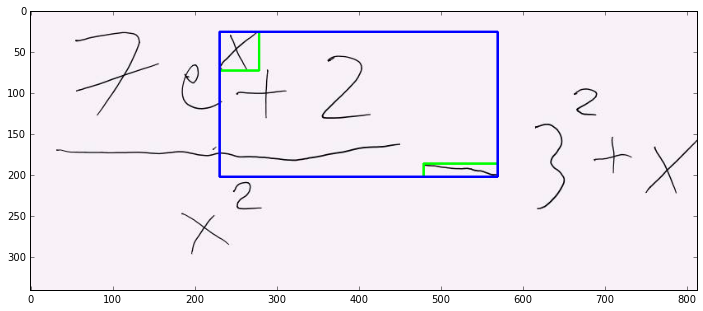

In [17]:
def make_box_around(rectangles):
    
    left = 1000000000
    top = 1000000000
    
    right = -1
    bottom = -1
    
    for [x, y, w, h] in rectangles:
        if x < left:
            left = x
        if x + w > right:
            right = x + w
        if y < top:
            top = y
        if y + h > bottom:
            bottom = y + h
    
    return [left, top, right - left, bottom - top]

first = random.randint(0, len(rectangles) - 1)
second = random.randint(0, len(rectangles) - 1)

container = make_box_around([rectangles[first], rectangles[second]])

res = img.copy()

draw_rect(res, rectangles[first], rect_color=(0, 255, 0))
draw_rect(res, rectangles[second], rect_color=(0, 255, 0))
draw_rect(res, container, rect_color=(0, 0, 255))

plt.imshow(res)

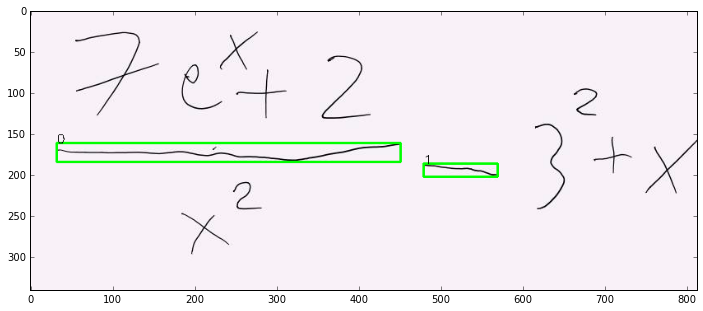

In [18]:
def is_horizontal_line(rectangle):
    [_, _, w, h] = rectangle
    return w * fraction_ratio_threshold > h

def find_horizontal_lines(rectangles):
    lines = [rectangle for rectangle in rectangles if is_horizontal_line(rectangle)]
    lines.sort(key=lambda r: -r[3])
    
    return lines

res = img.copy()

horizontal_lines = find_horizontal_lines(rectangles)

for k in range(len(horizontal_lines)):
    draw_rect(res, horizontal_lines[k], rect_color=(0,255,0), caption=str(k))

plt.imshow(res)

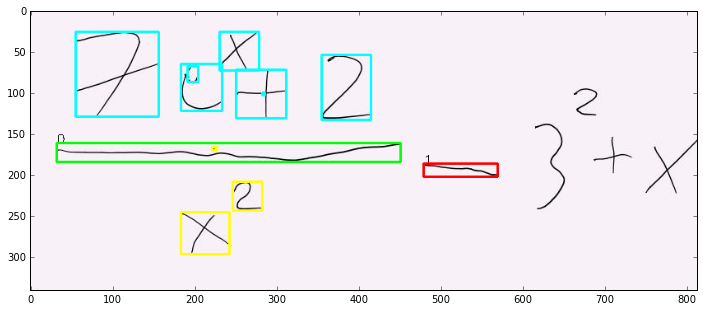

In [19]:
def find_fraction_parts(fraction_rect, rectangles):
    over = []
    under = []
    
    [x1, y1, w1, h1] = fraction_rect
    
    for rectangle in rectangles:
        if rectangle is fraction_rect:
            continue
        
        [x2, y2, w2, h2] = rectangle
        
        if x1 + w1 < x2 or x1 > x2 + w2:
            continue
        
        if y2 < y1:
            over.append(rectangle)
        else:
            under.append(rectangle)
    return (over, under)


for fraction in horizontal_lines:
    (over, under) = find_fraction_parts(fraction, rectangles)
    
    if len(over) is 0 or len(under) is 0:
        draw_rect(res, fraction, rect_color=(255,0,0))
    
    else:
        draw_rect(res, fraction, rect_color=(0,255,0))
        for rect in over:
            draw_rect(res, rect, rect_color=(0,255,255))
            
        for rect in under:
            draw_rect(res, rect, rect_color=(255,255,0))
    
plt.imshow(res)

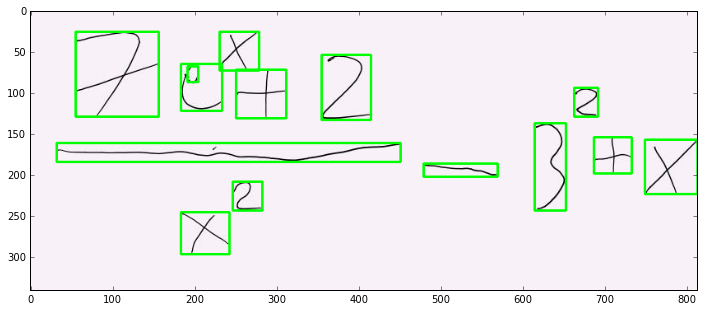

In [20]:
def area(r):
    [_, _, w, h] = r
    return w * h

def middle_area(rectangles):
    smallest = 10000000
    largest = 0
    
    for [_, _, w, h] in rectangles:
        a = w * h
        if a < smallest:
            smallest = a
        if a > largest:
            largest = a
    
    return (smallest + largest) * .5

def remove_tiny_rectangles(rectangles):
    global area_percentage_threshold
    
    middle = middle_area(rectangles)
    return [ rect for rect in rectangles if area(rect) > middle * area_percentage_threshold ]

rectangles = remove_tiny_rectangles(rectangles)

res = img.copy()
for rect in rectangles:
    draw_rect(res, rect, rect_color=(0,255,0))

plt.imshow(res)

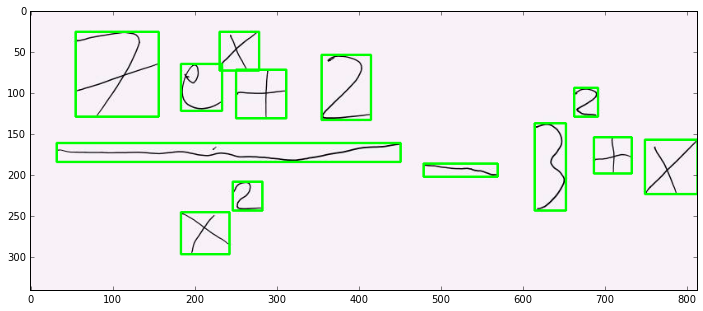

In [21]:
def intersection(r1, r2):
    [x1, y1, w1, h1] = r1
    [x2, y2, w2, h2] = r2
    
    left = max(x1, x2)
    right = min(x1 + w1, x2 + w2)
    
    if left > right:
        return None
    
    top = max(y1, y2)
    bottom = min(y1 + h1, y2 + h2)
    
    if top > bottom:
        return None
    
    return [left, top, right - left, bottom - top]

res = img.copy()

def remove_overlapping_rectangles(rectangles):
    global area_overlapping_threshold
    
    to_remove = []
    for i in range(len(rectangles)):
        for j in range(i+1, len(rectangles)):
            inter = intersection(rectangles[i], rectangles[j])

            if inter is None:
                continue

            area_i = area(rectangles[i])
            area_j = area(rectangles[j])
            area_inter = area(inter)

            if area_inter > area_overlapping_threshold * min(area_i, area_j):
                to_remove.append(rectangles[i if area_i < area_j else j])

    return [rect for rect in rectangles if rect not in to_remove]

res = img.copy()
rectangles = remove_overlapping_rectangles(rectangles)
            
for rect in rectangles:
    draw_rect(res, rect, rect_color=(0,255,0))
            
plt.imshow(res)


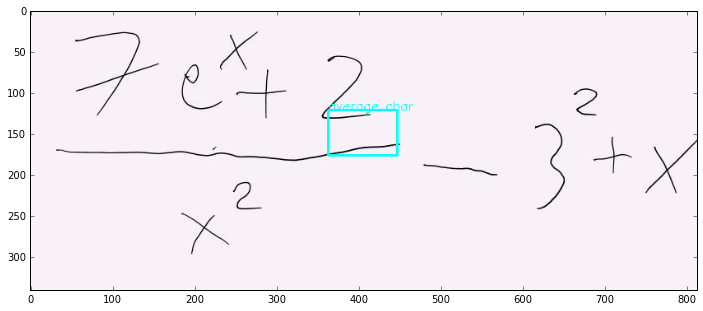

In [22]:
def average_rect(rectangles):
    return [
        int(np.mean(map(lambda r: r[0], rectangles))),
        int(np.mean(map(lambda r: r[1], rectangles))),
        int(np.mean(map(lambda r: r[2], rectangles))),
        int(np.mean(map(lambda r: r[3], rectangles)))
    ]

average = average_rect(rectangles)

res = img.copy()
draw_rect(res, average, caption="average char", rect_color=(0, 255, 255), caption_color=(0, 255, 255))
plt.imshow(res)

In [23]:
def should_merge(rectangles, r1, r2):    
    [_, _, _, average_height] = average_rect(rectangles) 

    [x1,y1,w1,h1] = r1
    [x2,y2,w2,h2] = r2
    
    # first we want to make sure that the two rectangles are on top of each other
    if (x1 > x2 + w2 * .5) or (x2 > x1 + w1 * .5):
        return False
    
    # then we make sure that the two boxes are not too far from another vertically
    return min(abs(y1 - y2 - h2), abs(y2 - y1 - h1)) < average_height * 0.5


res = img.copy()

for i in range(0, len(rectangles)):
    r1 = rectangles[i]

    for j in range(i + 1, len(rectangles)):
        r2 = rectangles[j]
        
        if should_merge(rectangles, r1, r2):
            bounding_box = make_box_around(r1, r2)
            draw_rect(res, r1, rect_color=(255,0,0))
            draw_rect(res, r2, rect_color=(255,0,0))
            draw_rect(res, bounding_box, rect_color=(0, 255, 0))
                        
plt.imshow(res)

TypeError: make_box_around() takes exactly 1 argument (2 given)

In [ ]:
def apply_merges(rectangles):
    to_remove = []
    to_add = []
    
    for i in range(0, len(rectangles)):
        r1 = rectangles[i]

        for j in range(i + 1, len(rectangles)):
            r2 = rectangles[j]

            if should_merge(rectangles, r1, r2):
                to_remove.append(i)
                to_remove.append(j)
                
                to_add.append(make_box_around(r1, r2))
    
    return [ rectangles[i] for i in range(len(rectangles)) if i not in to_remove ] + to_add

rectangles = apply_merges(rectangles)

res = img.copy()

for k in range(len(rectangles)):
    draw_rect(res, rectangles[k], rect_color=(0,255,0), caption=str(k))
    
plt.imshow(res)

In [ ]:
res = img.copy()

rectangles.sort(cmp=lambda r1, r2: r1[0] - r2[0])

for k in range(len(rectangles)):
    draw_rect(res, rectangles[k], rect_color=(0,255,0), caption=str(k))

plt.imshow(res)    

In [ ]:
def rect_corners(r):
    [x, y, w, h] = r
    return [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]

def rect_center(r):
    [x, y, w, h] = r
    return (int(x + w / 2), int(y + h / 2))

def distance(p1, p2):
    (p1x, p1y) = p1
    (p2x, p2y) = p2
    
    return (p1x - p2x) ** 2 + (p1y - p2y) ** 2

def find_decorated_symbols(rectangles):
    symbols = []
    
    for k in range(len(rectangles)):
        (tl_1, tr_1, br_1, bl_1) = rect_corners(rectangles[k])
        [x, y, w, h] = rectangles[k]
        radius = w / 2
        center = rect_center(rectangles[k])
        
        exp_dist = 100000000
        exp_index = None
        
        ind_dist = 100000000
        ind_index = None
        
        for j in range(k + 1, len(rectangles)):
            (tl_2, tr_2, br_2, bl_2) = rect_corners(rectangles[j])
            
            current_exp_dist = min(distance(tr_1, bl_2), distance(center, bl_2))
            current_ind_dist = min(distance(br_1, tl_2), distance(center, tl_2))
            
            if current_exp_dist < radius**2 and current_exp_dist < exp_dist and bl_2[1] < center[1]:
                exp_dist = current_exp_dist
                exp_index = j             
                
            if current_ind_dist < radius**2 and current_ind_dist < ind_dist and tl_2[1] > center[1]:
                ind_dist = current_ind_dist
                ind_index = j
        
        symbols.append((k, exp_index, ind_index))

    return symbols
    
    
res = img.copy()

decorated_symbols = find_decorated_symbols(rectangles)

for (index, exp_index, ind_index) in decorated_symbols:
    draw_rect(res, rectangles[index], rect_color=(200,200,200))
    
for (index, exp_index, ind_index) in decorated_symbols:
    radius = rectangles[index][2] / 2
    
    (_, tr_1, br_1, _) = rect_corners(rectangles[index])
    
    if exp_index is not None:
        (_, _, _, bl_2) = rect_corners(rectangles[exp_index])
        cv2.line(res, tr_1, bl_2, (0,255,0))
        cv2.circle(res, tr_1, radius, (0,0,255))
        
    if ind_index is not None:
        (tl_2, _, _, _) = rect_corners(rectangles[ind_index])
        cv2.line(res, br_1, tl_2, (0,255,0))
        cv2.circle(res, br_1, radius, (0,0,255))        
        
plt.imshow(res)

In [ ]:
res = img.copy()

def find_decoration_lines(rectangles, rect_info):
    (index, exp, ind) = rect_info
    
    rect = rectangles[index]
    (_, center_y) = rect_center(rect)
    
    exp_parts = []
    ind_parts = []
    
    if exp is None and ind is None:
        return ([], [])
    
    for next_rect in rectangles[index+1:]:
        [_, y, _, h] = next_rect
        
        if exp is not None and y + h < center_y:
            exp_parts.append(next_rect)
        elif ind is not None and  y > center_y:
            ind_parts.append(next_rect)
        elif y < center_y:
            break
            
    return (exp_parts, ind_parts)


non_main = []

for symbol_info in decorated_symbols:
    (exp_line, ind_line) = find_decoration_lines(rectangles, symbol_info)
    
    non_main = non_main + exp_line + ind_line
    
    if len(exp_line) > 0:
        exp_bb = make_box_around(exp_line[0], exp_line[-1])
        draw_rect(res, exp_bb, rect_color=(0,255,0))
    
    if len(ind_line) > 0:
        ind_bb = make_box_around(ind_line[0], ind_line[-1])
        draw_rect(res, ind_bb, rect_color=(0,0,255))
    
main = [rect for rect in rectangles if rect not in non_main]
for rect in main:
    draw_rect(res, rect, rect_color=(200,200,200))
    
plt.imshow(res)

In [ ]:
res = img.copy()
res_str = ""

for rect in main:
    index = rectangles.index(rect)
    (exp_line, ind_line) = find_decoration_lines(rectangles, decorated_symbols[index])
    
    res_str += str(index)
    
    if len(ind_line) > 0:
        res_str += "_{" + " -> ".join([str(rectangles.index(rect)) for rect in ind_line]) + "}"
    
    if len(exp_line) > 0:
        res_str += "^{" + " -> ".join([str(rectangles.index(rect)) for rect in exp_line]) + "}"
    
    res_str += " -> "
    
for k in range(len(rectangles)):
    draw_rect(res, rectangles[k], rect_color=(255,0,255), caption=str(k))
    
print res_str
plt.imshow(res)